# Project: M5 Forecasting
#### The M5 forecasting challenge focuses on predicting unit sales of Walmart products in California, Texas, and Wisconsin for the next 28 days using hierarchical sales data. The dataset includes item-level, department, category, store details, prices, promotions, and special events to improve forecasting accuracy.

DATA SOURCE: https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview

## DATA LOADING

### load libraries

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np


### load dataset

In [5]:
data_dir = Path("/Users/khoatran/coding/ML/pp#3/data")  

# Read the CSV file
calendar = pd.read_csv(data_dir/'calendar.csv')
train_eva = pd.read_csv(data_dir/'sales_train_evaluation.csv')
train_valid = pd.read_csv(data_dir/'sales_train_validation.csv')
sample_sub = pd.read_csv(data_dir/'sample_submission.csv')
sell_price = pd.read_csv(data_dir/'sell_prices.csv')


### UNDERSTANDING DATA

##### datasets decriptions
- calendar: Contains information about the dates on which the products are sold.
- train_eva:  Includes sales [d_1 - d_1941]
- train_valid: Contains the historical daily unit sales data per product and store [d_1 - d_1913]
- sample_sub: The correct format for submissions
- sell_price: Contains information about the price of the products sold per store and date

In [6]:
train_valid.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


note: 
- there are columns id for overall id (the combination of columns item_id and store_id with validation at the end), some dif 'id' columns: item_id, dept_id, cat_id, store_id, state_id
- they days from 1 to 1913 has been split as each day is each columns, and the values seem to be the number of that item was sold on that day

In [7]:
train_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [8]:
# Check missing values
print(train_valid.isna().sum()[train_valid.isna().sum() > 0])


Series([], dtype: int64)


no output -> no missing values at any rows

In [9]:
calendar.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


note: Some columns can be quite hard to understand:
- wm_yk_week: the year and the week number within that year, for example 11101 means the first week of 2011
- wday: week day (starts from saturday and end at friday)

In [10]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


4 event columns contains missing data, it is easy to understand because there is not like that event occur everyday

In [11]:
#convert date from object to date tiime type
calendar['date'] = pd.to_datetime(calendar['date'])

In [12]:
calendar['event_name_1'].unique()

array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [13]:
calendar['event_type_1'].unique()

array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [14]:
calendar['event_name_2'].unique()

array([nan, 'Easter', 'Cinco De Mayo', 'OrthodoxEaster', "Father's day"],
      dtype=object)

In [15]:
calendar['event_type_2'].unique()

array([nan, 'Cultural', 'Religious'], dtype=object)

#### we'll solve it latter, after merging data, we can use some method like one-hot encoder or else but we need evaluate the contribution of these columns first

In [16]:
sell_price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [17]:
sell_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [18]:
sell_price = sell_price[sell_price["store_id"].isin(["CA_1", "CA_2", "CA_3", "CA_4"])]


In [19]:
sell_price.shape

(2708822, 4)

In [20]:
missing_values = sell_price.isna().sum()
missing_values

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

### MERGING 2 DATA FRAME

In [21]:
melt_df = train_valid.melt(
    id_vars=["id", "item_id", "store_id", "dept_id", "cat_id", "state_id"],
    var_name='d',
    value_name='sales'
)

In [22]:
melt_df.head(10)

,id,item_id,store_id,dept_id,cat_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,CA_1,HOBBIES_1,HOBBIES,CA,d_1,12
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,CA_1,HOBBIES_1,HOBBIES,CA,d_1,2
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0


In [23]:
melt_df.shape

(58327370, 8)

In [24]:
df = melt_df.merge(calendar, on='d')

In [25]:
df.tail(10)

,id,item_id,store_id,dept_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
58327360,FOODS_3_818_WI_3_validation,FOODS_3_818,WI_3,FOODS_3,FOODS,WI,d_1913,1,2016-04-24,11613,...,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
58327361,FOODS_3_819_WI_3_validation,FOODS_3_819,WI_3,FOODS_3,FOODS,WI,d_1913,2,2016-04-24,11613,...,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
58327362,FOODS_3_820_WI_3_validation,FOODS_3_820,WI_3,FOODS_3,FOODS,WI,d_1913,1,2016-04-24,11613,...,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
58327363,FOODS_3_821_WI_3_validation,FOODS_3_821,WI_3,FOODS_3,FOODS,WI,d_1913,0,2016-04-24,11613,...,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
58327364,FOODS_3_822_WI_3_validation,FOODS_3_822,WI_3,FOODS_3,FOODS,WI,d_1913,1,2016-04-24,11613,...,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,WI_3,FOODS_3,FOODS,WI,d_1913,1,2016-04-24,11613,...,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,WI_3,FOODS_3,FOODS,WI,d_1913,0,2016-04-24,11613,...,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,WI_3,FOODS_3,FOODS,WI,d_1913,0,2016-04-24,11613,...,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,WI_3,FOODS_3,FOODS,WI,d_1913,3,2016-04-24,11613,...,2,4,2016,NaN,NaN,NaN,NaN,0,0,0
58327369,FOODS_3_827_WI_3_validation,FOODS_3_827,WI_3,FOODS_3,FOODS,WI,d_1913,0,2016-04-24,11613,...,2,4,2016,NaN,NaN,NaN,NaN,0,0,0


In [26]:
df.shape

(58327370, 21)

In [27]:
df['state_id'].unique()

array(['CA', 'TX', 'WI'], dtype=object)

### FEATURES ENGINEERING

### I want to focus on predicting sale on California, so i will drop samples on TX and WI

In [28]:
df = df[df['state_id'] == 'CA']

In [29]:
df.shape

(23330948, 21)

In [30]:
df = df.drop(columns=['snap_TX', 'snap_WI'])

In [31]:
df.head()

,id,item_id,store_id,dept_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0


In [32]:
df = df.merge(sell_price, on=['store_id', 'item_id', 'wm_yr_wk'], how='inner')

### PROCESSING event_name and event_type

In [33]:
df["event_name_encoded"] = df["event_name_1"].astype("category").cat.codes
df["event_type_encoded"] = df["event_type_1"].astype("category").cat.codes


In [73]:
#df['event_name_encoded'].corr(df['event_type_encoded'])
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["event_name_encoded"] = le.fit_transform(df["event_name_1"])
df["event_type_encoded"] = le.fit_transform(df["event_type_1"])


from sklearn.feature_selection import mutual_info_classif

mi_score1 = mutual_info_classif(df[['event_name_encoded']], df['event_type_encoded'], discrete_features=True)
print("Mutual Information Score:", mi_score1[0])


Mutual Information Score: 0.3832035023056212


In [35]:
'''df["event_name_encoded2"] = df["event_name_2"].astype("category").cat.codes
df["event_type_encoded2"] = df["event_type_2"].astype("category").cat.codes
df['event_name_encoded2'].corr(df['event_type_encoded2'])'''

'df["event_name_encoded2"] = df["event_name_2"].astype("category").cat.codes\ndf["event_type_encoded2"] = df["event_type_2"].astype("category").cat.codes\ndf[\'event_name_encoded2\'].corr(df[\'event_type_encoded2\'])'

#### since the event name and event type have more than 0.8 correlation -> we should drop one of them
since event name is larger than type -> drop event name

In [36]:
#df = df.drop(columns=['event_name_encoded', 'event_name_1', 'event_name_encoded2', 'event_name_2', 'event_type_encoded', 'event_type_encoded2'])

In [37]:
df.head()

,id,item_id,store_id,dept_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price,event_name_encoded,event_type_encoded
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,CA_1,HOBBIES_1,HOBBIES,CA,d_1,12,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0.46,-1,-1
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,CA_1,HOBBIES_1,HOBBIES,CA,d_1,2,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,1.56,-1,-1
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,3.17,-1,-1
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,CA_1,HOBBIES_1,HOBBIES,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,5.98,-1,-1
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,CA_1,HOBBIES_1,HOBBIES,CA,d_1,4,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0.70,-1,-1


In [38]:
def day_format_convert(d):
    d = str(d)  
    return d.split('_')[1] if '_' in d else None

In [39]:
df['d'] = df['d'].apply(day_format_convert)

In [40]:
df.head()

,id,item_id,store_id,dept_id,cat_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price,event_name_encoded,event_type_encoded
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,CA_1,HOBBIES_1,HOBBIES,CA,1,12,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0.46,-1,-1
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,CA_1,HOBBIES_1,HOBBIES,CA,1,2,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,1.56,-1,-1
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,CA_1,HOBBIES_1,HOBBIES,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,3.17,-1,-1
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,CA_1,HOBBIES_1,HOBBIES,CA,1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,5.98,-1,-1
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,CA_1,HOBBIES_1,HOBBIES,CA,1,4,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0.70,-1,-1


#### Since i focusing on only Cali so i can drop unuseful columns like state_id, we also can drop item_id because it just the unique id of each item

In [41]:
df = df.drop(columns=['state_id', 'item_id'])

In [42]:
df.head()

,id,store_id,dept_id,cat_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price,event_name_encoded,event_type_encoded
0,HOBBIES_1_008_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,12,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0.46,-1,-1
1,HOBBIES_1_009_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,2,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,1.56,-1,-1
2,HOBBIES_1_010_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,3.17,-1,-1
3,HOBBIES_1_012_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,5.98,-1,-1
4,HOBBIES_1_015_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,4,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0.70,-1,-1


In [43]:
df['id'].nunique()

12196

#### CREATE LAGGED FEATURES COLUMNS

In [44]:
lags = [7, 14, 28]
for lag in lags:
    df[f"lag_{lag}"] = df.groupby("id")["sales"].shift(lag)

In [45]:
df.head()

,id,store_id,dept_id,cat_id,d,sales,date,wm_yr_wk,weekday,wday,...,event_type_1,event_name_2,event_type_2,snap_CA,sell_price,event_name_encoded,event_type_encoded,lag_7,lag_14,lag_28
0,HOBBIES_1_008_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,12,2011-01-29,11101,Saturday,1,...,NaN,NaN,NaN,0,0.46,-1,-1,NaN,NaN,NaN
1,HOBBIES_1_009_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,2,2011-01-29,11101,Saturday,1,...,NaN,NaN,NaN,0,1.56,-1,-1,NaN,NaN,NaN
2,HOBBIES_1_010_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,0,2011-01-29,11101,Saturday,1,...,NaN,NaN,NaN,0,3.17,-1,-1,NaN,NaN,NaN
3,HOBBIES_1_012_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,0,2011-01-29,11101,Saturday,1,...,NaN,NaN,NaN,0,5.98,-1,-1,NaN,NaN,NaN
4,HOBBIES_1_015_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,4,2011-01-29,11101,Saturday,1,...,NaN,NaN,NaN,0,0.70,-1,-1,NaN,NaN,NaN


#### CATEGORICAL ENCODING and NaN VALUES PROCESSING

In [46]:
#store_id
df['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4'], dtype=object)

- lets discover what is CA_1 CA_2 CA_3 and CA_4, are these nominal or ordinal
- lets count them first and then see the average sales of them to estimate

In [47]:
store_counts = df["store_id"].value_counts()
print(store_counts)


store_id
CA_1    4702895
CA_3    4671941
CA_4    4567186
CA_2    4275776
Name: count, dtype: int64


In [48]:
store_sales_avg = df.groupby("store_id")["sales"].mean().reset_index()
print(store_sales_avg)


  store_id     sales
0     CA_1  1.636910
1     CA_2  1.329694
2     CA_3  2.394761
3     CA_4  0.898513


/var/folders/5n/r6b07v4s5cs3379jq_dtb8q00000gn/T/ipykernel_61839/219536725.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="store_id", y="sales", data=store_sales_avg, palette="viridis")


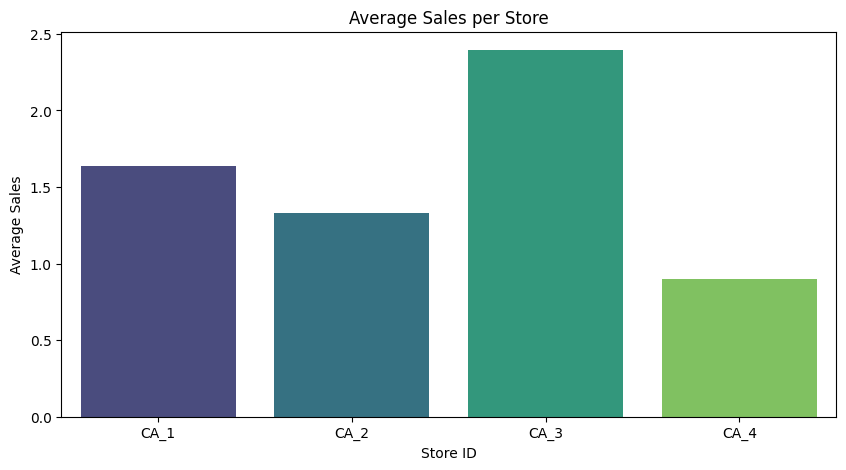

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.barplot(x="store_id", y="sales", data=store_sales_avg, palette="viridis")

plt.xlabel("Store ID")
plt.ylabel("Average Sales")
plt.title("Average Sales per Store")
plt.show()

#### As see above, i can say that store_id is nominal feature and there are only 4 unique value -> one-hot encoding

In [50]:
from sklearn.preprocessing import OneHotEncoder

In [51]:
OHencoder = OneHotEncoder(sparse_output=False)
OHencoder.fit(df[["store_id"]])
OHencoded = OHencoder.transform(df[["store_id"]])
encode_df = pd.DataFrame(OHencoded, columns=OHencoder.get_feature_names_out(["store_id"]))

In [52]:
df = pd.concat([df, encode_df], axis=1)

In [53]:
df.head()

,id,store_id,dept_id,cat_id,d,sales,date,wm_yr_wk,weekday,wday,...,sell_price,event_name_encoded,event_type_encoded,lag_7,lag_14,lag_28,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4
0,HOBBIES_1_008_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,12,2011-01-29,11101,Saturday,1,...,0.46,-1,-1,NaN,NaN,NaN,1.0,0.0,0.0,0.0
1,HOBBIES_1_009_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,2,2011-01-29,11101,Saturday,1,...,1.56,-1,-1,NaN,NaN,NaN,1.0,0.0,0.0,0.0
2,HOBBIES_1_010_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,0,2011-01-29,11101,Saturday,1,...,3.17,-1,-1,NaN,NaN,NaN,1.0,0.0,0.0,0.0
3,HOBBIES_1_012_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,0,2011-01-29,11101,Saturday,1,...,5.98,-1,-1,NaN,NaN,NaN,1.0,0.0,0.0,0.0
4,HOBBIES_1_015_CA_1_validation,CA_1,HOBBIES_1,HOBBIES,1,4,2011-01-29,11101,Saturday,1,...,0.70,-1,-1,NaN,NaN,NaN,1.0,0.0,0.0,0.0


In [54]:
df= df.drop(columns=['store_id'])

#### check correlation beween dept_id and cat_id

In [55]:
#first let say their unqiue value
df['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

In [56]:
df['dept_id'].unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

#### mutual information

In [57]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df["cat_id_encoded"] = le.fit_transform(df["cat_id"])
df["dept_id_encoded"] = le.fit_transform(df["dept_id"])


from sklearn.feature_selection import mutual_info_classif

mi_score = mutual_info_classif(df[['cat_id_encoded']], df['dept_id_encoded'], discrete_features=True)
print("Mutual Information Score:", mi_score[0])


Mutual Information Score: 1.0384409070666696


In [82]:
df.drop(columns=['cat_id_encoded', 'dept_id_encoded'], inplace=True)

In [84]:
df.columns

Index(['id', 'cat_id', 'd', 'sales', 'wm_yr_wk', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'sell_price', 'event_name_encoded', 'event_type_encoded',
       'lag_7', 'lag_14', 'lag_28', 'store_id_CA_1', 'store_id_CA_2',
       'store_id_CA_3', 'store_id_CA_4'],
      dtype='object')

In [89]:
# one hot encoding for cat_id and dept_id
OHencoder = OneHotEncoder(sparse_output=False)
OHencoder.fit(df[["cat_id"]])
OHencoded = OHencoder.transform(df[["cat_id"]])
encoded_df1 = pd.DataFrame(OHencoded, columns=OHencoder.get_feature_names_out(["cat_id"]))
df = pd.concat([df, encoded_df1], axis=1)

# Drop the original 'cat_id' column (optional)
df.drop(columns=["cat_id"], inplace=True)

In [91]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Define categorical columns to one-hot encode
categorical_cols = ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]

# Initialize OneHotEncoder
OHencoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")  # Prevent errors with unseen categories

# Fit & transform the categorical columns
OHencoded = OHencoder.fit_transform(df[categorical_cols])

# Convert to DataFrame
encoded_df = pd.DataFrame(OHencoded, columns=OHencoder.get_feature_names_out(categorical_cols))

# Merge the new one-hot encoded features back to the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop the original categorical columns (optional)
df.drop(columns=categorical_cols, inplace=True)

In [92]:
df.columns

Index(['id', 'd', 'sales', 'wm_yr_wk', 'wday', 'month', 'year', 'snap_CA',
       'sell_price', 'event_name_encoded', 'event_type_encoded', 'lag_7',
       'lag_14', 'lag_28', 'store_id_CA_1', 'store_id_CA_2', 'store_id_CA_3',
       'store_id_CA_4', 'cat_id_FOODS', 'cat_id_HOBBIES', 'cat_id_HOUSEHOLD',
       'event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father's day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach E

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18217798 entries, 0 to 18217797
Data columns (total 65 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   id                                object 
 1   d                                 int64  
 2   sales                             int64  
 3   wm_yr_wk                          int64  
 4   wday                              int64  
 5   month                             int64  
 6   year                              int64  
 7   snap_CA                           int64  
 8   sell_price                        float64
 9   event_name_encoded                int64  
 10  event_type_encoded                int64  
 11  lag_7                             float64
 12  lag_14                            float64
 13  lag_28                            float64
 14  store_id_CA_1                     float64
 15  store_id_CA_2                     float64
 16  store_id_CA_3                     

Since we already have a column that specify which store is that, so i think we will choose the cat_id columns

In [71]:
df = df.drop(columns=['dept_id'])

### CONSIDER FEATURES THAT SHOWS INFORMATION ABOUT TIME

In [59]:
#first, i will delete the columns that has have the same information with other
df = df.drop(columns=['weekday'])

In [60]:
df.head()

,id,dept_id,cat_id,d,sales,date,wm_yr_wk,wday,month,year,...,event_type_encoded,lag_7,lag_14,lag_28,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,cat_id_encoded,dept_id_encoded
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1,HOBBIES,1,12,2011-01-29,11101,1,1,2011,...,-1,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1,3
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1,HOBBIES,1,2,2011-01-29,11101,1,1,2011,...,-1,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1,3
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1,HOBBIES,1,0,2011-01-29,11101,1,1,2011,...,-1,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1,3
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1,HOBBIES,1,0,2011-01-29,11101,1,1,2011,...,-1,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1,3
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1,HOBBIES,1,4,2011-01-29,11101,1,1,2011,...,-1,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1,3


In [61]:
df.columns

Index(['id', 'dept_id', 'cat_id', 'd', 'sales', 'date', 'wm_yr_wk', 'wday',
       'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'sell_price', 'event_name_encoded',
       'event_type_encoded', 'lag_7', 'lag_14', 'lag_28', 'store_id_CA_1',
       'store_id_CA_2', 'store_id_CA_3', 'store_id_CA_4', 'cat_id_encoded',
       'dept_id_encoded'],
      dtype='object')

##### we have multiple features that shows information about time:  'date', 'wm_yr_wk', 'wday', 'month','year'
- I would drop 'date' first because it shows redundant information that month, year, wday have shown
- Then i will check the correlation between the rest

In [62]:
df = df.drop(columns=['date'])

In [63]:
#lets visualize the correclation through heatmap of wm_yr_wk and d and wday, month and year
#plt.figure(figsize=(10, 5))
#sns.heatmap(df[["wm_yr_wk", "d", "wday", "month", "year"]].corr(), annot=True, cmap="viridis")


- year, wm_yr_wk and d has significant correlation, lets consider which to be drop, since d is important (since we predict sale of each item in next 28 days)
- wday is not correlated with other features → Keep it.
- month has a weak correlation with year but may still capture seasonality.


In [64]:
#lets check each correlation with sales column and compare it 
#df['wm_yr_wk'].corr(df['sales'])


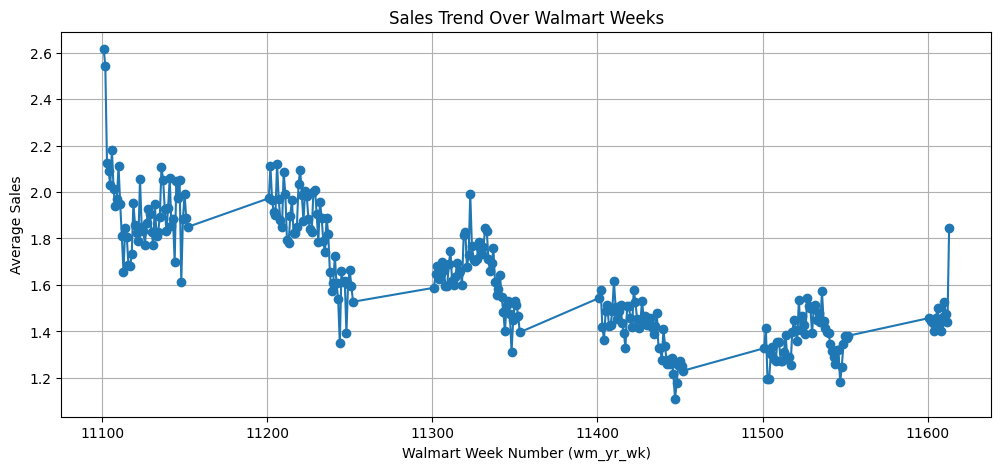

In [65]:
weekly_sales = df.groupby("wm_yr_wk")["sales"].mean()

plt.figure(figsize=(12, 5))
plt.plot(weekly_sales.index, weekly_sales.values, marker='o', linestyle='-')
plt.xlabel("Walmart Week Number (wm_yr_wk)")
plt.ylabel("Average Sales")
plt.title("Sales Trend Over Walmart Weeks")
plt.grid()
plt.show()

##### The data shows the trend, but I think it would be better if we use year to determine it

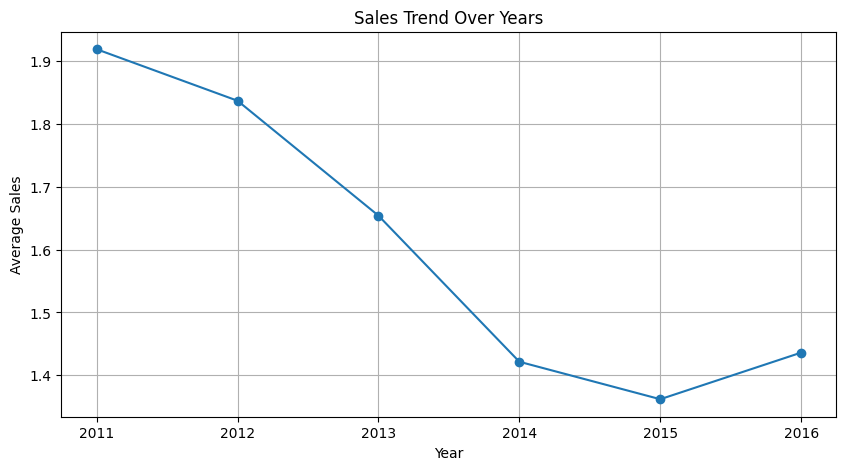

In [66]:
yearly_sales = df.groupby("year")["sales"].mean()

plt.figure(figsize=(10, 5))
plt.plot(yearly_sales.index, yearly_sales.values, marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Average Sales")
plt.title("Sales Trend Over Years")
plt.grid()
plt.show()

Since year shows a clear trend but i think d can present it as a day index

In [67]:
#correlation = df[["year", "wm_yr_wk", "sales"]].corr()
#print(correlation)

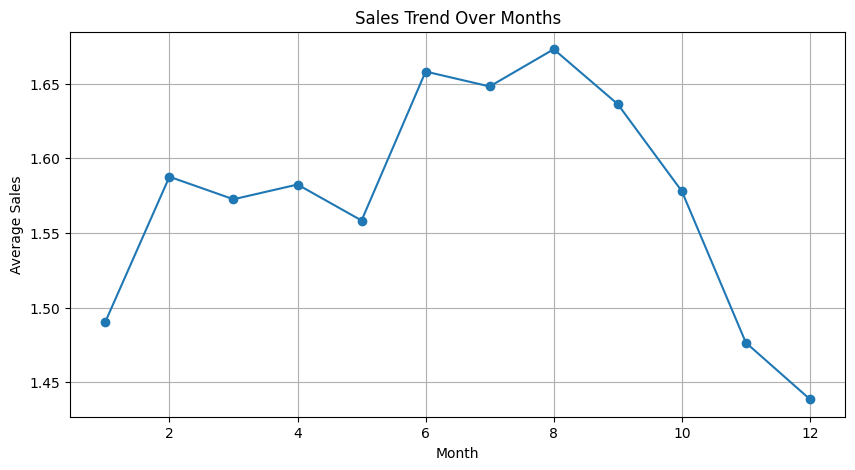

In [68]:
monthly_sales = df.groupby("month")["sales"].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-')
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.title("Sales Trend Over Months")
plt.grid()
plt.show()

In [69]:
#df = df.drop(columns=['wm_yr_wk', 'year'])

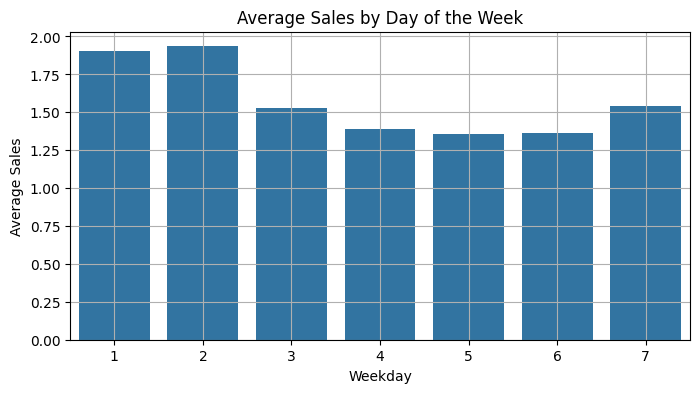

In [70]:
avg_sales_weekday = df.groupby("wday")["sales"].mean()

plt.figure(figsize=(8, 4))
sns.barplot(x=avg_sales_weekday.index, y=avg_sales_weekday.values)
plt.xlabel("Weekday")
plt.ylabel("Average Sales")
plt.title("Average Sales by Day of the Week")
plt.grid()
plt.show()


##### as 1 and 2 represents satudays and sundays, it makes sense that the sales is a little bit higher, as friday and monthday the sales even higher than tues, wed and thurs

In [94]:
df.columns

Index(['id', 'd', 'sales', 'wm_yr_wk', 'wday', 'month', 'year', 'snap_CA',
       'sell_price', 'event_name_encoded', 'event_type_encoded', 'lag_7',
       'lag_14', 'lag_28', 'store_id_CA_1', 'store_id_CA_2', 'store_id_CA_3',
       'store_id_CA_4', 'cat_id_FOODS', 'cat_id_HOBBIES', 'cat_id_HOUSEHOLD',
       'event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father's day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach E

In [ ]:
df.shape

In [95]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Define features and target
df["d"] = df["d"].astype(int)

features = [
    "d", "wm_yr_wk", "wday", "month", "year", "snap_CA",
    "sell_price", "event_name_encoded", "event_type_encoded", "lag_7",
    "lag_14", "lag_28", "store_id_CA_1", "store_id_CA_2", "store_id_CA_3",
    "store_id_CA_4", "cat_id_FOODS", "cat_id_HOBBIES", "cat_id_HOUSEHOLD",
    "event_name_1_Chanukah End", "event_name_1_Christmas",
    "event_name_1_Cinco De Mayo", "event_name_1_ColumbusDay",
    "event_name_1_Easter", "event_name_1_Eid al-Fitr",
    "event_name_1_EidAlAdha", "event_name_1_Father's day",
    "event_name_1_Halloween", "event_name_1_IndependenceDay",
    "event_name_1_LaborDay", "event_name_1_LentStart",
    "event_name_1_LentWeek2", "event_name_1_MartinLutherKingDay",
    "event_name_1_MemorialDay", "event_name_1_Mother's day",
    "event_name_1_NBAFinalsEnd", "event_name_1_NBAFinalsStart",
    "event_name_1_NewYear", "event_name_1_OrthodoxChristmas",
    "event_name_1_OrthodoxEaster", "event_name_1_Pesach End",
    "event_name_1_PresidentsDay", "event_name_1_Purim End",
    "event_name_1_Ramadan starts", "event_name_1_StPatricksDay",
    "event_name_1_SuperBowl", "event_name_1_Thanksgiving",
    "event_name_1_ValentinesDay", "event_name_1_VeteransDay",
    "event_name_1_nan", "event_type_1_Cultural", "event_type_1_National",
    "event_type_1_Religious", "event_type_1_Sporting", "event_type_1_nan",
    "event_name_2_Cinco De Mayo", "event_name_2_Easter",
    "event_name_2_Father's day", "event_name_2_OrthodoxEaster",
    "event_name_2_nan", "event_type_2_Cultural", "event_type_2_Religious",
    "event_type_2_nan"
]


# Identify categorical features




# Define target variable
X = df[features]
y = df['sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.DataFrame(
    {"Feature": X.columns, "Importance": lgb_model.feature_importances_}
).sort_values(by="Importance", ascending=False)

# Display feature importance
print(feature_importances)


: 